In [59]:
import pandas as pd 
import matplotlib.pyplot as plt

In [60]:
df = pd.read_excel("données_libération.xlsx")

chaque séries d'expériences sont stockées dans leurs variables respectives

In [61]:
Toposar_df = df[df["Formulation"] == "Toposar"].reset_index(drop=True)
Toposar_df_exp_1 = Toposar_df[Toposar_df["Expérience"] == 1].reset_index(drop=True)
Toposar_df_exp_2 = Toposar_df[Toposar_df["Expérience"] == 2].reset_index(drop=True)

In [62]:
NC_df = df[df["Formulation"] == "NC"].reset_index(drop=True)
NC_df_exp_1 = NC_df[NC_df["Expérience"] == 1].reset_index(drop=True)
NC_df_exp_2 = NC_df[NC_df["Expérience"] == 2].reset_index(drop=True)

In [63]:
serie_temps = NC_df_exp_1["Temps"]

Voici un graphe traçant les valeurs de fraction libérée de chaque série en fonction du temps

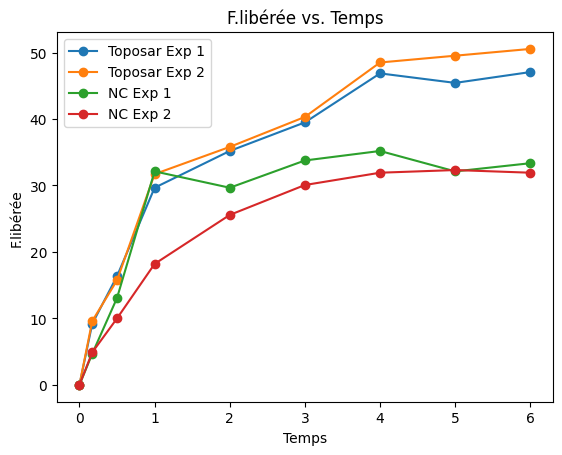

In [64]:

plt.plot(serie_temps, Toposar_df_exp_1["F.libérée"], label='Toposar Exp 1', marker='o')
plt.plot(serie_temps, Toposar_df_exp_2["F.libérée"], label='Toposar Exp 2', marker='o')
plt.plot(serie_temps, NC_df_exp_1["F.libérée"], label='NC Exp 1', marker='o')
plt.plot(serie_temps, NC_df_exp_2["F.libérée"], label='NC Exp 2', marker='o')


plt.title('F.libérée vs. Temps')
plt.xlabel('Temps')
plt.ylabel('F.libérée')


plt.legend()

plt.show()

cette fonction nous permet de trouver les paramètres d'une fonction décrivant une distribution monocompartimentale pour une série de valeur 

c:\Users\lukam\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


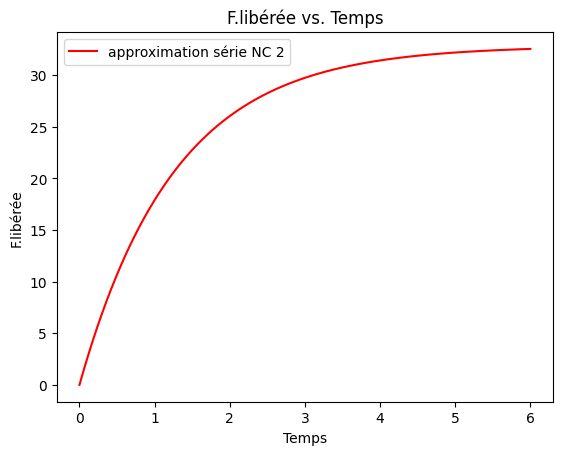

In [65]:
import numpy as np
from scipy.optimize import curve_fit

fit_results = {}

def monocomp_function(t, A, B, k):
    return A - A * np.exp(-k * t)

popt, pcov = curve_fit(monocomp_function, NC_df_exp_2["Temps"], NC_df_exp_2["F.libérée"], p0=[max(df["F.libérée"]), 1, 0.1], maxfev=10000)
fit_results["formulation"] = {'params': popt, 'covariance': pcov}
time_values = np.linspace(min(NC_df_exp_2["Temps"]), max(NC_df_exp_2["Temps"]), 500)
plt.plot(time_values, monocomp_function(time_values, *popt), label='approximation série NC 2', color='red')
plt.title('F.libérée vs. Temps')
plt.xlabel('Temps')
plt.ylabel('F.libérée')

# Show legend
plt.legend()

# Display the plot
plt.show()

nous pouvons donc modéliser une fonction approximant les valeurs de nos séries, ci-dessous la série de la 2ème expérience avec la formulation des nanocristaux

nous pouvons ainsi en déduire les paramètres de la fonction approximant cette série

In [66]:
A, B, k = popt
print("A: ", A,
"B: ", B,
"k: ", k)


A:  32.820633401565765 B:  1.0 k:  0.78778171689002


voici traçées les fonctions approximant les valeurs de chaque série

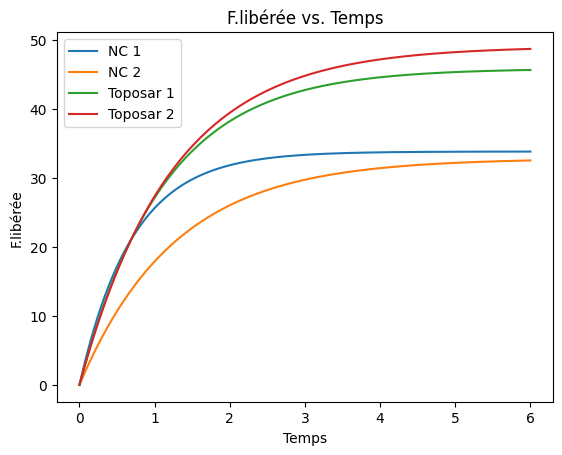

In [67]:
def plot_func(temps, f_lib, name):
    def monocomp_function(t, A, B, k):
        return A - A * np.exp(-k * t)
    popt, pcov = curve_fit(monocomp_function, temps, f_lib, p0=[max(f_lib), 1, 0.1], maxfev=10000)
    time_values = np.linspace(min(temps), max(temps), 500)
    plt.plot(time_values, monocomp_function(time_values, *popt), label=name)
plot_func(serie_temps, NC_df_exp_1["F.libérée"], "NC 1")
plot_func(serie_temps, NC_df_exp_2["F.libérée"], "NC 2")
plot_func(serie_temps, Toposar_df_exp_1["F.libérée"], "Toposar 1")
plot_func(serie_temps, Toposar_df_exp_2["F.libérée"], "Toposar 2")
plt.title('F.libérée vs. Temps')
plt.xlabel('Temps')
plt.ylabel('F.libérée')
plt.legend()

Nous avons utilisé ANOVA pour comparer les 2 séries d'expérience pour chaque formulation, en commençant par les nanocristaux : 

In [68]:
# Importation du module stats de SciPy pour les analyses statistiques
from scipy import stats

# Exécution d'une ANOVA à un facteur (F-test) pour comparer les moyennes de la fraction libérée
# entre deux expériences différentes pour le groupe NC
anova_result = stats.f_oneway(NC_df_exp_1["F.libérée"], NC_df_exp_2["F.libérée"])

# Affichage du résultat de l'ANOVA
print(anova_result)


F_onewayResult(statistic=0.26481918755027956, pvalue=0.6138636176897975)


puis ensuite le Toposar

In [69]:
from scipy import stats

anova_result = stats.f_oneway(Toposar_df_exp_1["F.libérée"], Toposar_df_exp_2["F.libérée"])

anova_result

F_onewayResult(statistic=0.02641159401051536, pvalue=0.8729339609709437)

Le modèle utilisé pour approximer au mieux le jeu de données intègre des variables catégorielles, permettant des ajustements spécifiques pour chaque groupe :

$$ F(t, \text{cat}) = (A + \delta_{\text{cat}}) \cdot (1 - e^{-(k + \epsilon_{\text{cat}})t}) $$

où :

$t$ représente le temps

$\text{cat}$ indique la catégorie (par exemple, Toposar expérience 1, Toposar expérience 2, NC expérience 1, NC expérience 2)

$A$ et $k$ sont les paramètres de base du modèle

$\delta_{\text{cat}}$ et $\epsilon_{\text{cat}}$ sont les ajustements des paramètres $A$ et $k$, respectivement, pour chaque catégorie.



In [70]:
# Importation de la fonction d'optimisation minimize de scipy
from scipy.optimize import minimize

# Préparation des catégories pour les données: 0 pour Toposar 1, 1 pour Toposar 2, etc.
category = np.array([0]*9 + [1]*9 + [2]*9 + [3]*9)

# Fonction modèle généralisée prenant en compte les ajustements par catégorie
def generalized_model(params, t, cat):
    # Paramètres de base A et k
    A, k = params[:2]
    # Ajustements delta_A et delta_k pour chaque catégorie
    delta_A = params[2 + cat*2]
    delta_k = params[3 + cat*2]
    # Calcul de la valeur de la fonction avec ajustements
    A_cat = A + delta_A
    k_cat = k + delta_k
    return A_cat * (1 - np.exp(-k_cat * t))

# Fonction objective à minimiser: somme des carrés des résidus
def objective_function(params, t, f_liberee, cat):
    # Calcul des prédictions pour chaque point de données et calcul des résidus
    predictions = np.array([generalized_model(params, t[i], cat[i]) for i in range(len(t))])
    # Somme des carrés des différences entre prédictions et observations
    return np.sum((predictions - f_liberee) ** 2)

# Deviner initialement les paramètres pour l'optimisation
initial_guess = [45, 1] + [0, 0]*4  # A, k, et ajustements initiaux pour chaque catégorie

# Exécution de l'optimisation pour minimiser la fonction objective
result = minimize(objective_function, initial_guess, args=(df["Temps"], df["F.libérée"], category), method='L-BFGS-B')

# Affichage des paramètres optimisés
result.x



array([41.3118803 ,  0.9830321 ,  4.54436129, -0.08760819,  7.74850341,
       -0.16861058, -7.48943961,  0.43447149, -8.49155353, -0.19522921])

In [71]:
plt.plot(serie_temps, Toposar_df_exp_1["F.libérée"], label='Toposar Exp 1', marker='o')
plt.plot(serie_temps, Toposar_df_exp_2["F.libérée"], label='Toposar Exp 2', marker='o')
plt.plot(serie_temps, NC_df_exp_1["F.libérée"], label='NC Exp 1', marker='o')
plt.plot(serie_temps, NC_df_exp_2["F.libérée"], label='NC Exp 2', marker='o')
plt.plot(time_values, monocomp_function(time_values, 41.3118803 , 1,0.9830321  ) , label='model approximation')

plt.title('F.libérée vs. Temps')
plt.xlabel('Temps')
plt.ylabel('F.libérée')

plt.legend()
plt.show()

nous avons utilisé ce même programme pour produire le modèle approximant le groupe d'expérience des Toposar : 

In [ ]:
from scipy.optimize import minimize
import numpy as np

category = np.array([0]*9 + [1]*9)  

def generalized_model(params, t, cat):
    A, k = params[:2]
    delta_A = params[2 + cat*2] 
    delta_k = params[3 + cat*2]  
    A_cat = A + delta_A
    k_cat = k + delta_k
    return A_cat * (1 - np.exp(-k_cat * t))

# Fonction objective à minimiser
def objective_function(params, t, f_liberee, cat):
    predictions = np.array([generalized_model(params, t[i], cat[i]) for i in range(len(t))])
    return np.sum((predictions - f_liberee) ** 2)

initial_guess = [50, 1] + [0, 0]*2  

result = minimize(objective_function, initial_guess, args=(Toposar_df["Temps"], Toposar_df["F.libérée"], category), method='L-BFGS-B')

result.x


array([ 4.83055443e+01,  9.03274262e-01, -2.44939860e+00, -7.85977899e-03,
        7.54937917e-01, -8.88568634e-02])

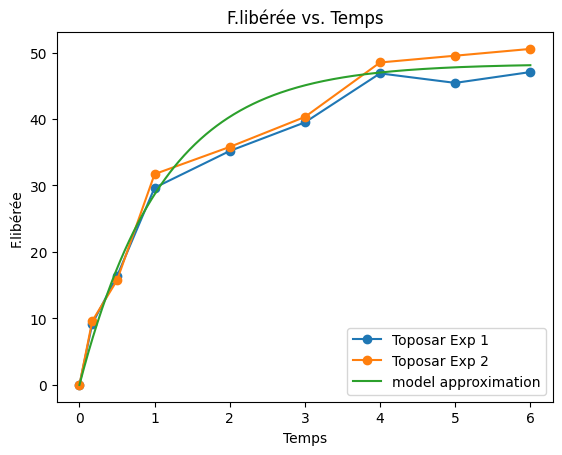

In [ ]:
plt.plot(serie_temps, Toposar_df_exp_1["F.libérée"], label='Toposar Exp 1', marker='o')
plt.plot(serie_temps, Toposar_df_exp_2["F.libérée"], label='Toposar Exp 2', marker='o')
plt.plot(time_values, monocomp_function(time_values,48.31, 1, 0.9 ) , label='model approximation')

plt.title('F.libérée vs. Temps')
plt.xlabel('Temps')
plt.ylabel('F.libérée')

plt.legend()
plt.show()
# Show legend

nous avons utilisé ce même programme pour produire le modèle approximant le groupe d'expérience des NC

In [ ]:
from scipy.optimize import minimize
import numpy as np

category = np.array([0]*9 + [1]*9) 

def generalized_model(params, t, cat):
    A, k = params[:2]
    delta_A = params[2 + cat*2]  
    delta_k = params[3 + cat*2]  
    A_cat = A + delta_A
    k_cat = k + delta_k
    return A_cat * (1 - np.exp(-k_cat * t))

def objective_function(params, t, f_liberee, cat):
    predictions = np.array([generalized_model(params, t[i], cat[i]) for i in range(len(t))])
    return np.sum((predictions - f_liberee) ** 2)

initial_guess = [35, 1] + [0, 0]*2  



result = minimize(objective_function, initial_guess, args=(NC_df["Temps"], NC_df["F.libérée"], category), method='L-BFGS-B')


result.x

array([33.88097849,  1.06844381, -0.05867515,  0.34910535, -1.06034561,
       -0.28066209])

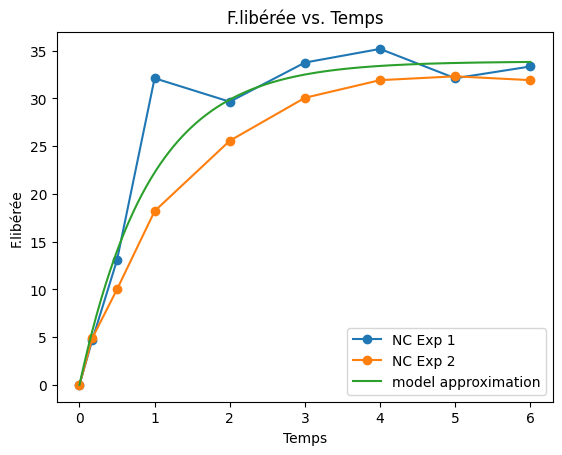

In [ ]:
plt.plot(serie_temps, NC_df_exp_1["F.libérée"], label='NC Exp 1', marker='o')
plt.plot(serie_temps, NC_df_exp_2["F.libérée"], label='NC Exp 2', marker='o')
plt.plot(time_values, monocomp_function(time_values,33.88097849, 1, 1.06844339 ) , label='model approximation')


plt.title('F.libérée vs. Temps')
plt.xlabel('Temps')
plt.ylabel('F.libérée')

plt.legend()
plt.show()

à partir des paramètres obtenues pour chaque modèle, nous pouvons ainsi calculer les résidues de chaque modèle : 

In [ ]:
#modèle approximant les 4 séries

# Définition de la fonction du modèle qui retourne la fraction libérée en fonction du temps t
# avec les paramètres A et k estimés précédemment
def model_function(t):
    return 42.31178488 * (1 - np.exp(-0.98304299 * t))

# Calcul des valeurs prédites par le modèle pour les temps observés dans le DataFrame df
f_predicted = model_function(df["Temps"])

# Calcul des résidus (différence entre les valeurs observées et prédites)
# puis élevation au carré de ces différences pour obtenir les carrés des résidus
squared_residuals = (df["F.libérée"] - f_predicted) ** 2

# Somme des carrés des résidus (SSR) pour évaluer l'ajustement global du modèle
ssr = np.sum(squared_residuals)


In [ ]:
#modèle approximant le Toposar

def model_function(t):
    return 48.31 * (1 - np.exp(-0.90 * t))

f_predicted = model_function(Toposar_df["Temps"])

squared_residuals = (Toposar_df["F.libérée"] - f_predicted) ** 2


ssr = np.sum(squared_residuals)

In [ ]:
#modèle approximant les nanocristaux
def model_function(t):
    return 38.88097853 * (1 - np.exp(-1.06844339 * t))


f_predicted = model_function(NC_df["Temps"])

squared_residuals = (NC_df["F.libérée"] - f_predicted) ** 2

ssr = np.sum(squared_residuals)